In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 


In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load[2000:]]
valset = [texttoint[c] for c in load[:2000]]

sequence_length = 1
vocab_size = len(texttoint)
inputs = torch.tensor(dataset[:-1])
labels = torch.tensor(dataset[1:])
val_inputs = torch.tensor(valset[:-1])
val_labels = torch.tensor(valset[1:])

# Optimizer

The architecture looks right but the loss is not going down as well as expected, let's try changing simple gradient descent to a more elaborate optimizer <br>
We won't bother coding this up by ourselves because it's already implemented in pytorch and really easy to use from there <br>
If you want, you can change from torch.optim.Adam to torch.optim.SGD and look how fast Adam really is

Epoch ___0 - Loss: 4.191
Epoch _200 - Loss: 2.778
Epoch _400 - Loss: 2.578
Epoch _600 - Loss: 2.505
Epoch _800 - Loss: 2.501
Epoch 1000 - Loss: 2.413
Epoch 1200 - Loss: 2.550
Epoch 1400 - Loss: 2.596
Epoch 1600 - Loss: 2.479
Epoch 1800 - Loss: 2.396


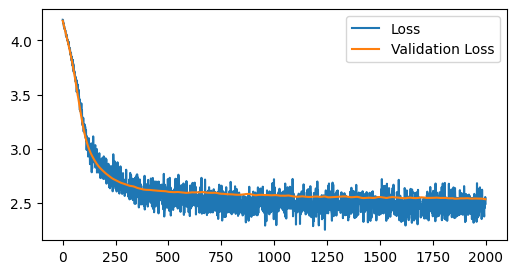

In [16]:
hidden_size = 128

w1 = torch.randn(vocab_size, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

params = [w1, b1, w2, b2]
for p in params:
    p.requires_grad_()

epochs = 2000
batch_size = 256
optimizer = torch.optim.Adam(params, lr=1e-3)
lossi = []
vlossi = [] 

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    X = F.one_hot(inputs[indexes].long(), vocab_size).float()
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        X = F.one_hot(val_inputs.long(), vocab_size).float()
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

In [17]:
string = "The meaning of life is: \n"

with torch.no_grad():
    for _ in range(100):
        X = F.one_hot(torch.tensor(texttoint[string[-1]]), vocab_size).float()
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        string += inttotext[torch.multinomial(F.softmax(pred, dim=0), 1).item()]
        print(string[-1], end="")


Fithy winthe.
I sur.

QUE:
. erst bu he;
Bur d wile, reresersee f.
F:
KONTofm incctrwil puld; red w 

# Longer sequences (3 chars)
The outputs seem better than random, but we should aim at a loss way lower than 2.5... First thing that comes to mind is that we should give the model more context, because now we are just passing the last character

In [18]:
sequence_length = 3

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[:, :-1][2000:]
labels = sequences[:, -1][2000:]
val_inputs = sequences[:, :-1][:2000]  
val_labels = sequences[:, -1][:2000]

Epoch ___0 - Loss: 4.219
Epoch _200 - Loss: 2.679
Epoch _400 - Loss: 2.366
Epoch _600 - Loss: 2.365
Epoch _800 - Loss: 2.261
Epoch 1000 - Loss: 2.327
Epoch 1200 - Loss: 2.087
Epoch 1400 - Loss: 2.141
Epoch 1600 - Loss: 2.070
Epoch 1800 - Loss: 1.938


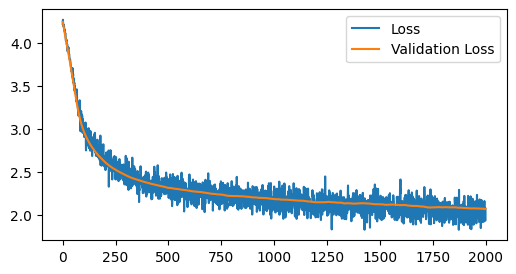

In [19]:
hidden_size = 128

w1 = torch.randn(vocab_size*sequence_length, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

params = [w1, b1, w2, b2]
for p in params:
    p.requires_grad_()


epochs = 2000
batch_size = 256
optimizer = torch.optim.Adam(params, lr=1e-3)
lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    X = F.one_hot(inputs[indexes].long(), vocab_size).float() # this has shape (batch_size, sequence_length, vocab_size), but we want (batch_size, vocab_size*sequence_length)
    X = X.reshape(batch_size, -1) # -1 means "infer the size from the other dimensions"
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        X = F.one_hot(val_inputs.long(), vocab_size).float()
        X = X.reshape(len(val_inputs), -1)
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Longer sequences (20 chars)


In [4]:
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[:, :-1][2000:]
labels = sequences[:, -1][2000:]
val_inputs = sequences[:, :-1][:2000]
val_labels = sequences[:, -1][:2000]

We are getting a way better loss, around 1.9 instead of 2.5 <br> 
Now let's try a wider input sequence, 20 should allow us to cover 3-5 words

Epoch ___0 - Loss: 4.692
Epoch _200 - Loss: 3.007
Epoch _400 - Loss: 2.668
Epoch _600 - Loss: 2.331
Epoch _800 - Loss: 2.148
Epoch 1000 - Loss: 2.265
Epoch 1200 - Loss: 2.148
Epoch 1400 - Loss: 2.244
Epoch 1600 - Loss: 2.127
Epoch 1800 - Loss: 2.230


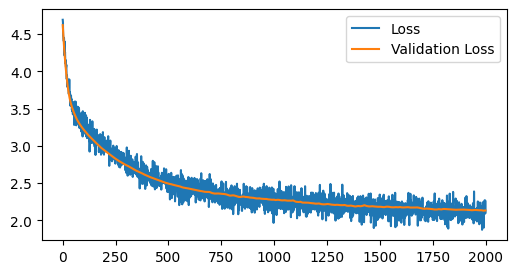

In [21]:
hidden_size = 128

w1 = torch.randn(vocab_size*sequence_length, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

params = [w1, b1, w2, b2]
for p in params:
    p.requires_grad_()

epochs = 2000
batch_size = 256
optimizer = torch.optim.Adam(params, lr=1e-3)
lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    X = F.one_hot(inputs[indexes].long(), vocab_size).float() # this has shape (batch_size, sequence_length, vocab_size), but we want (batch_size, vocab_size*sequence_length)
    X = X.reshape(batch_size, -1) # -1 means "infer the size from the other dimensions"
    h1 = F.gelu(X @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        X = F.one_hot(val_inputs.long(), vocab_size).float().view(len(val_inputs), -1)
        h1 = F.gelu(X @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Running this model took way too much (around 3 times longer than before), and it seems harder to optimize let's explore why... 

In [22]:
for param, name in zip([w1, b1, w2, b2], ["w1", "b1", "w2", "b2"]):
    # print variable name, shape and number of parameters
    print(name, param.shape, param.numel())   

w1 torch.Size([1300, 128]) 166400
b1 torch.Size([128]) 128
w2 torch.Size([128, 65]) 8320
b2 torch.Size([65]) 65


The first layer has WAAAY too many parameters, it scales with sequence_length * vocab_size * hidden_size <br>
How can we improve on this? <br>
- Lowering sequence_length decreases performance
- vocab_size seems oddly inefficient with one_hot embeddings [0, 0, 0, 0, 1, 0, 0, 0]
- Lowering hidden_size decreases performance 

Let's think about vocab_size, right now with one_hot embeddings we are using 65 parameters to store a small int <br> 
We can't pass the int by itself, because neural networks are not good at picking up small differences in int values like that. <br><br>
One idea would be to reduce the dimensionality to something more managable, like 5 parameters, but how? <br>
We could simply make a list initialized at random of 5 parameter embeddigs for each value in the vocabulary... We call these embeddings <br>

Embeddings not only allow us to be more parameter efficient than one_hot encoding, they have O(n) complexity and allow us to map each integer value in the input space to a trained vector space where each embedding trends towards a good representation for the meaning of the inputs. 

# Embeddings

Epoch ___0 - Loss: 4.199
Epoch _200 - Loss: 2.879
Epoch _400 - Loss: 2.505
Epoch _600 - Loss: 2.418
Epoch _800 - Loss: 2.370
Epoch 1000 - Loss: 2.311
Epoch 1200 - Loss: 2.393
Epoch 1400 - Loss: 2.366
Epoch 1600 - Loss: 2.222
Epoch 1800 - Loss: 2.346


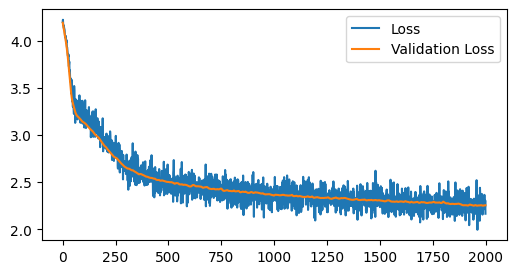

In [23]:
emb_size = 10  # I chose 10 parameter embeddings, but you can try different values
hidden_size = 128

embeddings = torch.randn(vocab_size, emb_size) / 10  # Assigning a random vector to each character in the vocabulary (this will be trained)
w1 = torch.randn(sequence_length*emb_size, hidden_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)  
b1 = torch.zeros(hidden_size) 
w2 = torch.randn(hidden_size, vocab_size) * (6**0.5 / (vocab_size + hidden_size)**0.5)
b2 = torch.zeros(vocab_size)

params = [embeddings, w1, b1, w2, b2]
for p in params:
    p.requires_grad_()

epochs = 2000
batch_size = 256
optimizer = torch.optim.Adam(params, lr=1e-3)  # dont forget to add embeddings to the optimizer
lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    emb = embeddings[inputs[indexes]].view(batch_size, -1)
    h1 = F.gelu(emb @ w1 + b1)
    pred = h1 @ w2 + b2
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        emb = embeddings[val_inputs].reshape(len(val_inputs), -1)
        h1 = F.gelu(emb @ w1 + b1)
        pred = h1 @ w2 + b2
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Moving to pytorch nn.Module for cleaner code and better initialization
As you can see the model runs well, but now the complexity of the code is getting problematic, luckily pytorch has most of this already implemented. 
Just like we did before with the loss and the optimizer, here we can substitute the layers with pre made ones. 

In [5]:
class MLP(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.w1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.w2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        h1 = F.gelu(self.w1(emb))
        return self.w2(h1)
    
model = MLP(emb_size=10, hidden_size=128)

Epoch ___0 - Loss: 4.189
Epoch _200 - Loss: 2.678
Epoch _400 - Loss: 2.598
Epoch _600 - Loss: 2.440
Epoch _800 - Loss: 2.348
Epoch 1000 - Loss: 2.315
Epoch 1200 - Loss: 2.380
Epoch 1400 - Loss: 2.238
Epoch 1600 - Loss: 2.126
Epoch 1800 - Loss: 2.129


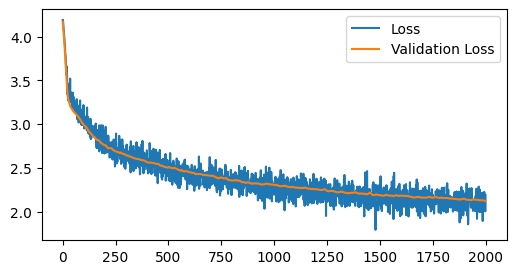

In [25]:
epochs = 2000
batch_size = 256
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes]) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs)
        vloss = F.cross_entropy(pred, val_labels)
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# GPUs for extremely fast parallel execution

As you can see the torch version works just as well, if not better and it's all around more refined

Using nn.Module class from pytorch also allows us to execute the code on the GPU, which is way faster


In [6]:
device = torch.device("cuda:0")  # Set the device to GPU (cuda) 
model = MLP(emb_size=10, hidden_size=128).to(device)  # Send the model to GPU

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
epochs = 10000
batch_size = 256
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device))  # Send the inputs to GPU
    loss = F.cross_entropy(pred, labels[indexes].to(device))  # Send the labels to GPU

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


The performance of the model is the same but everything happens in about a third of the time on my pc (ryzen 3100 and 3060 12GB) <br>
Note: GPUs are often bandwith bound, not compute bound, so higher batch sizes play well with text, for example it may be that from 1 to 512 the training time stays basically the same, because the gpu is able to compute all of these in parallel and under a certain batch size you will not be taking advantage of this. <br>
Now let's train it for a while and take a look at some predictions

In [ ]:
string = "             \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(1000):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        #print(X)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")


             
KING RICHARD IIIS:
Sy lothial, I whosed froy!

CORIOLANUS:
Enforely cresm prased, you there.

Secold bust me las what Bapains youl the shall darcess'd to rech limting ple.

TRANIO:
So keld need; make wereconsed acce abime singry thilds,
And therex Vimer!
Thouse of hea? by such a-bone;
But not trom yoult all my sentlemann ope,
Derengeans cray ness, I'lish, my with Covung, to guse have Mother?

AUCIO:
Nays my frompe to-lusse, mady thee gendinghants my bud bardin with wit broing hald again
Maugain ry gonnot kay' queed.

MISTB OFI
Than sey, you ligatiem, harge dy ped all.

QUEEN ELTZANganis, hat's be purgapss, and we pare,
How I more hath mathe, if, come asse our cartce oor maicherag be boot canst no, you aleat bust way:
And but we dactest fearsw.

BRUTUn:
Hifilt calich of woncanions
Youll be the makidon If awe,
Spectid
till is in Pamgody, in ther is spotter worthing in courn?

LUCENTIO:
To Mukay:
He herefur hence and. Whon sast he eactor.

CAPULET:
I, nor, if thes it truegh


The model is spitting out nosense but it clearly resembles the text it's trained on... Let's see how we can improve on this in part 5